In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import polars as pl
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 
import warnings

warnings.filterwarnings('ignore')

dataPath = "/kaggle/input/home-credit-credit-risk-model-stability/"

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-credit-credit-risk-model-stability/sample_submission.csv
/kaggle/input/home-credit-credit-risk-model-stability/feature_definitions.csv
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_deposit_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_applprev_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_cb_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_0.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_3.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_credit_bureau_a_1_2.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_tax_registry_b_1.parquet
/kaggle/input/home-credit-credit-risk-model-stability/parquet_files/test/test_static_0_2.parquet
/kaggle/input/home-credit-credit-risk-model-st

## **Goal of the Competition**

The goal of this competition is to predict which clients are more likely to default on their loans. The evaluation will favor solutions that are stable over time.

Your participation may offer consumer finance providers a more reliable and longer-lasting way to assess a potential client’s default risk.

## **Loading the Data**

We will now load the data and get it in the right format. We will conduct exploratory data analysis and create a baseline submission that we can iterate and improve on.

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

## **Feature Engineering**

We will join the tables on case_id. (There are additional ways we can work with the data, but we will leave this as is for now.)

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.6, random_state=1)
case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)

for df in [X_train, X_valid, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
X_submission = data_submission[cols_pred].to_pandas()
X_submission = convert_strings(X_submission)

In [9]:
print(f"Train: {X_train.shape}")
print(f"Valid: {X_valid.shape}")
print(f"Test: {X_test.shape}")

Train: (915995, 48)
Valid: (305332, 48)
Test: (305332, 48)


In [10]:
def fill_na(df, fill_value_numeric=0, fill_value_categorical='Missing', fill_value_default='Unknown'):
    """
    Fills missing values in a DataFrame.

    Parameters:
    df (pd.DataFrame): The DataFrame to fill missing values in.
    fill_value_numeric (int or float): The value to fill missing values with in numeric columns.
    fill_value_categorical (str): The value to fill missing values with in categorical columns.
    fill_value_default (str): The value to fill missing values with in other types of columns.

    Returns:
    pd.DataFrame: DataFrame with missing values filled.
    """
    for col in df.columns:
        if df[col].dtype.name == 'category':
            # Add a new category for missing values and fill with it
            df[col] = df[col].cat.add_categories([fill_value_categorical]).fillna(fill_value_categorical)
        elif pd.api.types.is_numeric_dtype(df[col]):
            # Fill numeric columns with the specified numeric value
            df[col] = df[col].fillna(fill_value_numeric)
        else:
            # Fill other types of columns with the specified default value
            df[col] = df[col].fillna(fill_value_default)
    return df


X_train= fill_na(X_train)
X_valid = fill_na(X_valid)
X_test = fill_na(X_test)
X_submission = fill_na(X_submission)

In [11]:
cat_cols = [col for col in X_train.columns if X_train[col].dtype == 'category']
num_cols = [col for col in X_train.columns if col not in cat_cols]

In [12]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    all_values = pd.concat([X_train[col], X_valid[col],X_test[col],X_submission[col]], axis=0).astype(str)
    le.fit(all_values)
    X_train[col] = le.transform(X_train[col].astype(str))
    X_valid[col] = le.transform(X_valid[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))
    X_submission[col] = le.transform(X_submission[col].astype(str))
    label_encoders[col] = le

X_test_combined = np.hstack([X_test[cat_cols].values, X_test[num_cols].values])
X_train_combined = np.hstack([X_train[cat_cols].values, X_train[num_cols].values])
X_valid_combined = np.hstack([X_valid[cat_cols].values, X_valid[num_cols].values])
X_submission_combined = np.hstack([X_submission[cat_cols].values, X_submission[num_cols].values])

X_test = X_test_combined.astype('float32')
X_train = X_train_combined.astype('float32')
X_valid = X_valid_combined.astype('float32')
X_submission = X_submission_combined.astype('float32')

In [13]:
print(type(X_train))
print(type(y_train))
print(type(X_valid))
print(type(y_valid))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>
<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


## **Deep Learning**

Deep learning is a type of machine learning that is used to teach artificial neural networks how to learn from vast amounts of data. These neural networks are designed to mimic the structure of the human brain, and they are composed of layers of interconnected nodes called neurons that work in concert to process and analyze information.

In the process of deep learning, the neural network is fed large amounts of data and then adjusts its parameters through a process called backpropagation to minimize the difference between its predicted output and the actual output. This allows the neural network to recognize patterns and make accurate predictions.

Deep learning has many practical applications, such as image and speech recognition, natural language processing, and self-driving cars. It has revolutionized the field of artificial intelligence and has contributed to significant advancements in research and development.

Basic

advanced NN

simplified ANN

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter

class SimplifiedResidualBlock(nn.Module):
    def __init__(self, in_features, out_features):
        super(SimplifiedResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(in_features, out_features),
            nn.BatchNorm1d(out_features),
            nn.LeakyReLU(),
            nn.Linear(out_features, out_features),
            nn.BatchNorm1d(out_features)
        )
        self.shortcut = nn.Sequential()
        if in_features != out_features:
            self.shortcut = nn.Sequential(
                nn.Linear(in_features, out_features),
                nn.BatchNorm1d(out_features),
            )

    def forward(self, x):
        identity = x
        out = self.block(x)
        out += self.shortcut(identity)
        return nn.ReLU()(out)

class SimplifiedAdvancedNeuralNetwork(nn.Module):
    def __init__(self, num_features):
        super(SimplifiedAdvancedNeuralNetwork, self).__init__()
        self.initial_layer = nn.Sequential(
            nn.Linear(num_features, 256),  # Reduced from 512 to 256
            nn.BatchNorm1d(256),
            nn.LeakyReLU()
        )
        self.residual_stack = nn.Sequential(
            SimplifiedResidualBlock(256, 128),
            nn.Dropout(0.1),  # Reduced dropout
            SimplifiedResidualBlock(128, 64)
        )
        self.final_layers = nn.Sequential(
            nn.Linear(64, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        out = self.initial_layer(x)
        out = self.residual_stack(out)
        out = self.final_layers(out)
        return out

# Assuming X_train is properly defined and is a tensor
num_features = X_train.shape[1]  # Adjust this according to your dataset

# Create the simplified model
model = SimplifiedAdvancedNeuralNetwork(num_features)

# Define the optimizer with weight decay for regularization
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Optionally use a cosine annealing learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)

# Define the loss function
criterion = nn.BCELoss()

# Set up TensorBoard
tensorboard_writer = SummaryWriter(log_dir='logs')

# Print the simplified model's architecture
print(model)


2024-05-07 15:26:27.601969: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-07 15:26:27.602076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-07 15:26:27.739598: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


SimplifiedAdvancedNeuralNetwork(
  (initial_layer): Sequential(
    (0): Linear(in_features=48, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.01)
  )
  (residual_stack): Sequential(
    (0): SimplifiedResidualBlock(
      (block): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.01)
        (3): Linear(in_features=128, out_features=128, bias=True)
        (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (shortcut): Sequential(
        (0): Linear(in_features=256, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Dropout(p=0.1, inplace=False)
    (2): SimplifiedResidualBlock(

In [15]:
import torch
from torch.utils.data import DataLoader, TensorDataset
import torchmetrics
import numpy as np

# Convert your data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.astype('float32'))
y_train_tensor = torch.tensor(y_train.astype('float32'))
X_valid_tensor = torch.tensor(X_valid.astype('float32'))
y_valid_tensor = torch.tensor(y_valid.astype('float32'))

print("tensor finished")
# Create TensorDataset objects
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
valid_dataset = TensorDataset(X_valid_tensor, y_valid_tensor)
print("dataset finished")
# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=4)
valid_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, num_workers=4)
print("dataloader finished")
# Training and Validation Functions with AUROC calculation
def train(model, criterion, optimizer, loader, auroc_metric):
    model.train()
    total_loss = 0
    auroc_metric.reset()
    for inputs, targets in loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        auroc_metric.update(outputs.sigmoid(), targets.int())  # Ensure outputs are sigmoid probabilities and targets are integers
    train_auroc = auroc_metric.compute()
    return total_loss / len(loader), train_auroc

def validate(model, criterion, loader, auroc_metric):
    model.eval()
    total_loss = 0
    auroc_metric.reset()
    with torch.no_grad():
        for inputs, targets in loader:
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            total_loss += loss.item()
            auroc_metric.update(outputs.sigmoid(), targets.int())  # Ensure outputs are sigmoid probabilities and targets are integers
    val_auroc = auroc_metric.compute()
    return total_loss / len(loader), val_auroc

# Metrics initialized correctly for binary classification
train_auroc_metric = torchmetrics.AUROC(task='binary')
valid_auroc_metric = torchmetrics.AUROC(task='binary')

# Initialize lists to store per-epoch training and validation loss and AUROC
train_losses = []
valid_losses = []
train_aurocs = []
valid_aurocs = []

print("getting into loop")
# Main training loop
epochs = 8
for epoch in range(epochs):
    print("epoch:",epoch)
    train_loss, train_auroc = train(model, criterion, optimizer, train_loader, train_auroc_metric)
    valid_loss, valid_auroc = validate(model, criterion, valid_loader, valid_auroc_metric)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    train_aurocs.append(train_auroc)
    valid_aurocs.append(valid_auroc)
    print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, Train AUROC: {train_auroc:.4f}, Valid AUROC: {valid_auroc:.4f}')

tensorboard_writer.close()

tensor finished
dataset finished
dataloader finished
getting into loop
epoch: 0
Epoch 1/8, Train Loss: 0.1345, Valid Loss: 0.1301, Train AUROC: 0.6750, Valid AUROC: 0.6989
epoch: 1
Epoch 2/8, Train Loss: 0.1323, Valid Loss: 0.1301, Train AUROC: 0.6941, Valid AUROC: 0.7066
epoch: 2
Epoch 3/8, Train Loss: 0.1318, Valid Loss: 0.1296, Train AUROC: 0.6997, Valid AUROC: 0.7049
epoch: 3
Epoch 4/8, Train Loss: 0.1316, Valid Loss: 0.1295, Train AUROC: 0.7015, Valid AUROC: 0.7039
epoch: 4
Epoch 5/8, Train Loss: 0.1317, Valid Loss: 0.1295, Train AUROC: 0.7010, Valid AUROC: 0.7067
epoch: 5
Epoch 6/8, Train Loss: 0.1315, Valid Loss: 0.1294, Train AUROC: 0.7030, Valid AUROC: 0.7064
epoch: 6
Epoch 7/8, Train Loss: 0.1314, Valid Loss: 0.1295, Train AUROC: 0.7038, Valid AUROC: 0.7097
epoch: 7
Epoch 8/8, Train Loss: 0.1313, Valid Loss: 0.1295, Train AUROC: 0.7049, Valid AUROC: 0.7059


In [16]:
# Assuming X_train is a numpy array or a similar data structure where .shape[1] gives the number of features
num_columns = X_train.shape[1]
print(num_columns)

48


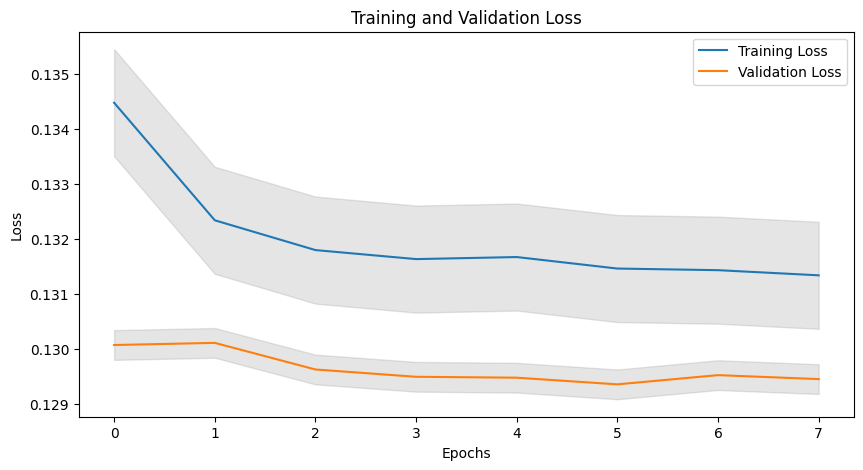

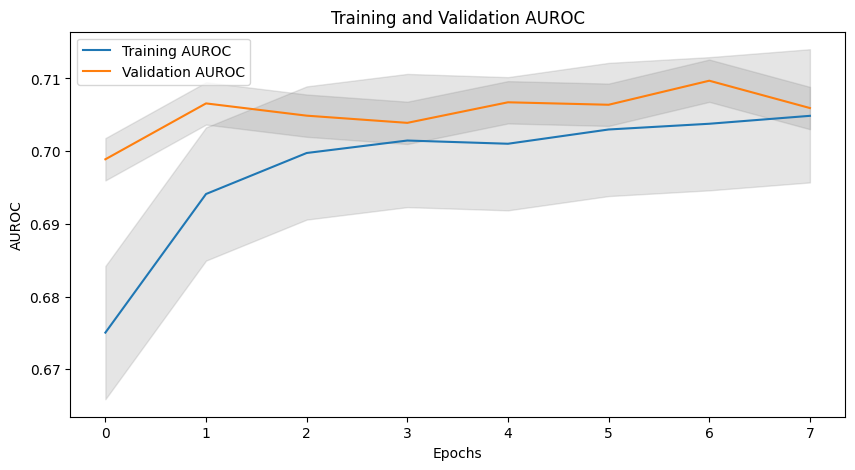

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Plot training and validation loss with standard deviation shading
plt.figure(figsize=(10, 5))

# Training loss and its standard deviation
train_loss_std = np.std(train_losses)
valid_loss_std = np.std(valid_losses)

plt.plot(train_losses, label='Training Loss')
plt.fill_between(range(len(train_losses)),
                 np.array(train_losses) - train_loss_std,
                 np.array(train_losses) + train_loss_std,
                 color='gray', alpha=0.2)

# Validation loss and its standard deviation
plt.plot(valid_losses, label='Validation Loss')
plt.fill_between(range(len(valid_losses)),
                 np.array(valid_losses) - valid_loss_std,
                 np.array(valid_losses) + valid_loss_std,
                 color='gray', alpha=0.2)

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation AUC with standard deviation shading
plt.figure(figsize=(10, 5))

# AUC standard deviation
train_auroc_std = np.std(train_aurocs)
valid_auroc_std = np.std(valid_aurocs)

plt.plot(train_aurocs, label='Training AUROC')
plt.fill_between(range(len(train_aurocs)),
                 np.array(train_aurocs) - train_auroc_std,
                 np.array(train_aurocs) + train_auroc_std,
                 color='gray', alpha=0.2)

plt.plot(valid_aurocs, label='Validation AUROC')
plt.fill_between(range(len(valid_aurocs)),
                 np.array(valid_aurocs) - valid_auroc_std,
                 np.array(valid_aurocs) + valid_auroc_std,
                 color='gray', alpha=0.2)

plt.title('Training and Validation AUROC')
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.legend()
plt.show()

After running the code, TensorBoard logs can be visualized using the following command. This will open a web interface where you can view the loss and other metrics.

In [18]:
# %load_ext tensorboard
# %tensorboard --logdir logs

We will now evaluate the neural network performance with AUC and gini stability below.

In [19]:
import torch
from sklearn.metrics import roc_auc_score

# Assuming model is your trained PyTorch model
model.eval()  # Set the model to evaluation mode

for base, X in [(base_train, X_train), (base_valid, X_valid), (base_test, X_test)]:
    # Convert data to PyTorch tensor
    X_tensor = torch.tensor(X.astype('float32'))
    
    # If using GPU, transfer data to GPU
    # X_tensor = X_tensor.to(device)  # Uncomment if you are using a device (GPU/CPU)

    # Get predictions from the neural network model
    with torch.no_grad():  # No need to track gradients for prediction
        y_pred = model(X_tensor).squeeze().numpy()  # .squeeze() to remove extra dimensions, .numpy() to convert to NumPy array
    
    # Store predictions in the DataFrame
    base["score"] = y_pred

# Print AUC scores using scikit-learn's roc_auc_score function
print(f'The AUC score on the train set is: {roc_auc_score(base_train["target"], base_train["score"])}') 
print(f'The AUC score on the valid set is: {roc_auc_score(base_valid["target"], base_valid["score"])}') 
print(f'The AUC score on the test set is: {roc_auc_score(base_test["target"], base_test["score"])}')

The AUC score on the train set is: 0.7116795176909101
The AUC score on the valid set is: 0.7059289855214705
The AUC score on the test set is: 0.7063531815674403


In [20]:
def gini_stability(base, w_fallingrate=88.0, w_resstd=-0.5):
    gini_in_time = base.loc[:, ["WEEK_NUM", "target", "score"]]\
        .sort_values("WEEK_NUM")\
        .groupby("WEEK_NUM")[["target", "score"]]\
        .apply(lambda x: 2*roc_auc_score(x["target"], x["score"])-1).tolist()
    
    x = np.arange(len(gini_in_time))
    y = gini_in_time
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = np.mean(gini_in_time)
    return avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std

stability_score_train = gini_stability(base_train)
stability_score_valid = gini_stability(base_valid)
stability_score_test = gini_stability(base_test)

print(f'The stability score on the train set is: {stability_score_train}') 
print(f'The stability score on the valid set is: {stability_score_valid}') 
print(f'The stability score on the test set is: {stability_score_test}')  

The stability score on the train set is: 0.3978097947642462
The stability score on the valid set is: 0.3797369627585283
The stability score on the test set is: 0.3800129314028726


## **Submission**

We will now make predictions with the neural network for the submission dataset.

In [21]:
import torch
import pandas as pd

# Assuming model is your trained PyTorch model and X_submission is your input features as a numpy array
model.eval()  # Set the model to evaluation mode

# Convert X_submission to a PyTorch tensor
X_submission_tensor = torch.tensor(X_submission.astype('float32'))

# Get predictions from the PyTorch model
with torch.no_grad():  # No need to track gradients for prediction
    y_submission_pred = model(X_submission_tensor).squeeze().numpy()

# Create a pandas DataFrame for submission
submission = pd.DataFrame({
    "case_id": data_submission["case_id"].to_numpy(),
    "score": y_submission_pred
}).set_index('case_id')

# # Save submission DataFrame to a CSV file
submission.to_csv("/kaggle/working/submission.csv")

# If you need to retrieve the file path to the saved CSV:
submission_file_path = "/kaggle/working//submission.csv"
print(f"Submission saved to: {submission_file_path}")

Submission saved to: /kaggle/working//submission.csv


View the submission dataframe.

In [22]:
submission

,score
case_id,
57543,0.032840
57549,0.031281
57551,0.009203
57552,0.022379
57569,0.039482
57630,0.030001
57631,0.051642
57632,0.004048
57633,0.042205
